In [ ]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00


In [ ]:
!pip install  pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 28.8 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import torch
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from pymorphy3 import MorphAnalyzer
from stop_words import get_stop_words
import string
from nltk import ngrams

from matplotlib import pyplot as plt
import seaborn as sns
import re

In [ ]:
# Загрузка запросов
queries = load_dataset(f"Cohere/miracl-ru-queries-22-12", split="dev")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.11k [00:00<?, ?B/s]

(…)-00000-of-00001-d1de06d6b6482a7a.parquet:   0%|          | 0.00/41.1M [00:00<?, ?B/s]

(…)-00000-of-00001-6014228512208659.parquet:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

(…)-00000-of-00001-78a4a011ae1dc086.parquet:   0%|          | 0.00/3.45M [00:00<?, ?B/s]

(…)-00000-of-00001-003543ac41b77cc0.parquet:   0%|          | 0.00/2.80M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4683 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1252 [00:00<?, ? examples/s]

Generating testA split:   0%|          | 0/911 [00:00<?, ? examples/s]

Generating testB split:   0%|          | 0/718 [00:00<?, ? examples/s]

In [ ]:
splits = {'train': 'data/train-00000-of-00001-d1de06d6b6482a7a.parquet', 'dev': 'data/dev-00000-of-00001-6014228512208659.parquet', 'testA': 'data/testA-00000-of-00001-78a4a011ae1dc086.parquet', 'testB': 'data/testB-00000-of-00001-003543ac41b77cc0.parquet'}
df_train = pd.read_parquet("hf://datasets/Cohere/miracl-ru-queries-22-12/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/Cohere/miracl-ru-queries-22-12/" + splits["dev"])

In [ ]:
df = pd.concat([df_train, df_test], axis= 0)

In [ ]:
aa= df.explode("positive_passages", ignore_index = True)
nf = pd.concat( [aa, pd.json_normalize(aa['positive_passages'])], axis=1)

In [ ]:
bb= df.explode("negative_passages", ignore_index = True)
nf1 = pd.concat( [bb, pd.json_normalize(bb['negative_passages'])], axis=1)

In [ ]:
pos = nf.drop(['positive_passages','negative_passages','emb', 'docid','title'], axis =1)

In [ ]:
neg = nf1.drop(['positive_passages','negative_passages','emb', 'docid','title'], axis =1)

In [ ]:
neg['label']= 0

In [ ]:
pos['label'] = 1

In [ ]:
neg1 = neg.dropna()

In [ ]:
new_df = pd.concat([pos, neg1] ,axis = 0)

In [ ]:
new_df = new_df.drop('query_id', axis =1)

In [ ]:
new_df = new_df.reset_index(drop= True)

In [ ]:
new_df

,query,text,label
0,Когда был спущен на воду первый миноносец «Спо...,Зачислен в списки ВМФ СССР 19 августа 1952 год...,1
1,Как долго существовало британское телевизионно...,"Хрустальный лабиринт (""The Crystal Maze"") — бр...",1
2,Когда родилась Князева Марина Леонидовна?,Князева Марина Леонидовна (род. 7 мая 1952 г.)...,1
3,Кто был главным художником мира Зен?,"В книге ""Half-Life 2: Raising the Bar"" художни...",1
4,Как звали предполагаемого убийцу Джона Кеннеди?,В 1966 году окружной прокурор Нового Орлеана Д...,1
...,...,...,...
47016,Кто убил Зорана Джинджича?,Смерть Зорана Джинджича была констатирована в ...,0
47017,Кто убил Зорана Джинджича?,"Аресты по делу Джинджича, однако, продолжились...",0
47018,Кто убил Зорана Джинджича?,Ратомир Живкович обвинил в организации убийств...,0
47019,Кто убил Зорана Джинджича?,В 12:25 (по свидетельству Биляны Станков и вод...,0


## EDA и Очистка текста

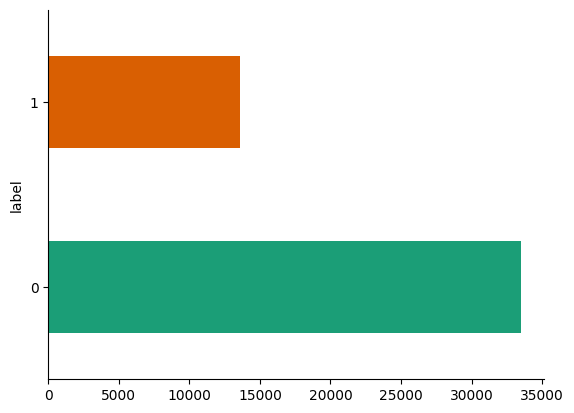

In [ ]:
#посмотри на баланс классов
new_df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Можно увидеть дисбаланс классов

(array([1.7693e+04, 2.1696e+04, 5.7160e+03, 1.2370e+03, 4.2200e+02,
        1.4300e+02, 5.4000e+01, 2.7000e+01, 1.3000e+01, 6.0000e+00,
        2.0000e+00, 4.0000e+00, 2.0000e+00, 3.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([7.000000e+00, 5.377500e+02, 1.068500e+03, 1.599250e+03,
        2.130000e+03, 2.660750e+03, 3.191500e+03, 3.722250e+03,
        4.253000e+03, 4.783750e+03, 5.314500e+03, 5.845250e+03,
        6.376000e+03, 6.906750e+03, 7.437500e+03, 7.968250e+03,
        8.499000e+03, 9.029750e+03, 9.560500e+03, 1.009125e+04,
        1.062200e+04]),
 <BarContainer object of 20 artists>)

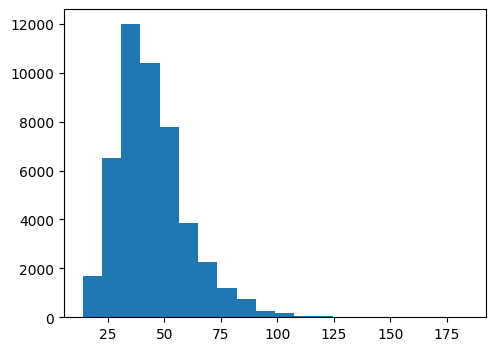

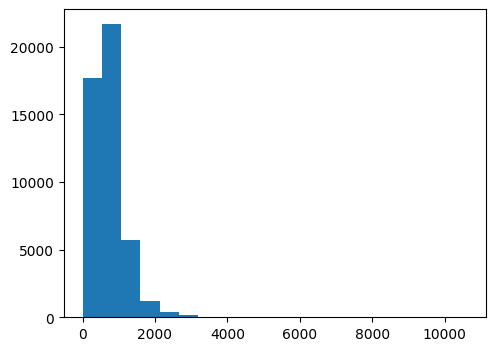

In [ ]:
#посмотрим распредление длин объектов из выборки
len_object_querty = new_df['query'].str.len()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(len_object_querty, bins = 20)

len_object_text = new_df['text'].str.len()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(len_object_text, bins = 20)

In [ ]:
len_object_querty.describe()

,query
count,47021.000000
mean,44.450118
std,16.103804
min,14.000000
25%,33.000000
50%,42.000000
75%,52.000000
max,184.000000


In [ ]:
len_object_text1 = new_df['text'].str.len()
len_object_text1.describe()


,text
count,47020.000000
mean,731.391514
std,453.582298
min,7.000000
25%,428.000000
50%,648.000000
75%,920.250000
max,9461.000000


In [ ]:
long_text = new_df['text'][(new_df['text'].str.len() > 6000)]
new_df = new_df.drop(long_text.index)

In [ ]:
len_object_text2 = new_df['text'].str.len()
len_object_text2.describe()

,text
count,47009.000000
mean,729.905656
std,442.829334
min,7.000000
25%,428.000000
50%,648.000000
75%,920.000000
max,5821.000000


Максимальная длина запроса 184 символа

In [ ]:
unique_words = new_df['text'].str.split().explode().nunique()
unique_words

560445

In [ ]:
new_df

,query,text,label
0,Когда был спущен на воду первый миноносец «Спо...,Зачислен в списки ВМФ СССР 19 августа 1952 год...,1
1,Как долго существовало британское телевизионно...,"Хрустальный лабиринт (""The Crystal Maze"") — бр...",1
2,Когда родилась Князева Марина Леонидовна?,Князева Марина Леонидовна (род. 7 мая 1952 г.)...,1
3,Кто был главным художником мира Зен?,"В книге ""Half-Life 2: Raising the Bar"" художни...",1
4,Как звали предполагаемого убийцу Джона Кеннеди?,В 1966 году окружной прокурор Нового Орлеана Д...,1
...,...,...,...
47016,Кто убил Зорана Джинджича?,Смерть Зорана Джинджича была констатирована в ...,0
47017,Кто убил Зорана Джинджича?,"Аресты по делу Джинджича, однако, продолжились...",0
47018,Кто убил Зорана Джинджича?,Ратомир Живкович обвинил в организации убийств...,0
47019,Кто убил Зорана Джинджича?,В 12:25 (по свидетельству Биляны Станков и вод...,0


## Очистка текста

In [ ]:
exclude = set(string.punctuation) # удаление пунктуации
stop_w = set(get_stop_words(language='ru')) # удаление стоп-слов
morpher = MorphAnalyzer() # леммантизатор

In [ ]:
symbols_pattern = re.compile(pattern = "["
    "@_!#$%^&*()<>?/\|}{~:√•—"
                       "]+", flags = re.UNICODE) #спецсимволы
# двойные пробелы
space_pattern = re.compile('\s+')
#ударения
without_accent = re.compile(r'([аеиоуыэюяё])́')

In [ ]:
def clear_text(text):
    """ Функция удаления спецсимволов"""
    # удаление спецсимволов и emoji
    pre = symbols_pattern.sub(r'',text)
    pre1 = without_accent.sub(r'\1',pre)
    # удаление двойных пробелов

    return space_pattern.sub(' ', pre1)

In [ ]:
def preprocess_text(text):
    """ Финальная функция для обработки """
    # srip + lower + punctuation
    sentence = (
        ''.join([x for x in str(text).strip().lower() if x not in exclude])
    )
    # лемматизация и стопслова
    sentence = (
        ' '.join([
            morpher.parse(word)[0].normal_form
            for word in sentence.split()
            if word not in stop_w ])
    )

    return clear_text(sentence)

In [ ]:
new_df['clean_text'] = new_df['text'].apply(preprocess_text)

In [ ]:
new_df['clean_query'] = new_df['query'].apply(preprocess_text)

In [ ]:
unique_words = new_df['clean_text'].str.split().explode().unique()

In [ ]:
new_df

,query,text,label,clean_text,clean_query
0,Когда был спущен на воду первый миноносец «Спо...,Зачислен в списки ВМФ СССР 19 августа 1952 год...,1,зачислить список вмф ссср 19 август 1952 офици...,спустить вода миноносец «спокойный»
1,Как долго существовало британское телевизионно...,"Хрустальный лабиринт (""The Crystal Maze"") — бр...",1,хрустальный лабиринт the crystal maze британск...,существовать британский телевизионный игровой ...
2,Когда родилась Князева Марина Леонидовна?,Князева Марина Леонидовна (род. 7 мая 1952 г.)...,1,князев марина леонидович родиться 7 май 1952 п...,родиться князев марина леонидович
3,Кто был главным художником мира Зен?,"В книге ""Half-Life 2: Raising the Bar"" художни...",1,книга halflife 2 raising the bar художник игра...,главный художник зен
4,Как звали предполагаемого убийцу Джона Кеннеди?,В 1966 году окружной прокурор Нового Орлеана Д...,1,1966 окружный прокурор новый орлеан джим гарри...,звать предполагать убийца джон кеннеди
...,...,...,...,...,...
47016,Кто убил Зорана Джинджича?,Смерть Зорана Джинджича была констатирована в ...,0,смерть зоран джинджич констатировать 1330 хиру...,убить зоран джинджич
47017,Кто убил Зорана Джинджича?,"Аресты по делу Джинджича, однако, продолжились...",0,арест дело джинджич продолжиться поскольку мно...,убить зоран джинджич
47018,Кто убил Зорана Джинджича?,Ратомир Живкович обвинил в организации убийств...,0,ратомиро живкович обвинить организация убийств...,убить зоран джинджич
47019,Кто убил Зорана Джинджича?,В 12:25 (по свидетельству Биляны Станков и вод...,0,1225 свидетельство биляна станок водитель алек...,убить зоран джинджич


In [ ]:
!pip install -U sentence-transformers

In [ ]:
from torch import cuda
from transformers import BertModel, BertTokenizer
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
input_query = [f"query: {queries}" for queries in new_df['query'].to_list()]
input_passage = [f"passage: {passages}" for passages in new_df['clean_text'].to_list()]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("deepvk/USER-bge-m3")
model = AutoModel.from_pretrained("deepvk/USER-bge-m3")
model.to(device)


XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(46166, 1024, padding_idx=1)
    (position_embeddings): Embedding(8194, 1024, padding_idx=1)
    (token_type_embeddings): Embedding(1, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0-23): 24 x XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwi

In [ ]:
def  get_sentence_embedding(text):
  input = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt')
  with torch.no_grad():
    model_output = model(**input)
  embeddings = model_output[0][:, 0]
  embeddings = torch.nn.functional.normalize(embeddings)
  return embeddings[0].numpy()


In [ ]:
def embed_cls(text):
    t = tokenizer(text, padding= True,  max_length=512,  return_tensors='pt' )
    with torch.no_grad():
      model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()


In [ ]:
new_df['embedding_text'] = new_df['clean_text'].apply(embed_cls)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2888: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [ ]:
new_df['embedding_query'] = new_df['clean_query'].apply(embed_cls)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2888: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [ ]:
new_df

,query,text,label,clean_text,clean_query,embedding_text,embedding_query
0,Когда был спущен на воду первый миноносец «Спо...,Зачислен в списки ВМФ СССР 19 августа 1952 год...,1,зачислить список вмф ссср 19 август 1952 офици...,спустить вода миноносец «спокойный»,"[-0.0028841891, -0.017563865, -0.01335567, 0.0...","[0.003920707, 0.02552749, -0.068968035, -0.026..."
1,Как долго существовало британское телевизионно...,"Хрустальный лабиринт (""The Crystal Maze"") — бр...",1,хрустальный лабиринт the crystal maze британск...,существовать британский телевизионный игровой ...,"[0.039296236, -0.0070944894, -0.010093204, -0....","[-0.014649218, 0.009323701, -0.016271587, -0.0..."
2,Когда родилась Князева Марина Леонидовна?,Князева Марина Леонидовна (род. 7 мая 1952 г.)...,1,князев марина леонидович родиться 7 май 1952 п...,родиться князев марина леонидович,"[-0.041850127, -0.004266698, -0.011352857, -0....","[-0.015897647, 0.019648572, -0.046639707, 0.00..."
3,Кто был главным художником мира Зен?,"В книге ""Half-Life 2: Raising the Bar"" художни...",1,книга halflife 2 raising the bar художник игра...,главный художник зен,"[-0.013497094, 0.0038514808, -0.03132848, 0.02...","[-0.010837633, 0.0013444135, -0.010544876, -0...."
4,Как звали предполагаемого убийцу Джона Кеннеди?,В 1966 году окружной прокурор Нового Орлеана Д...,1,1966 окружный прокурор новый орлеан джим гарри...,звать предполагать убийца джон кеннеди,"[0.022455405, -0.009529029, -0.036152314, 0.00...","[-0.018516973, 0.014874366, -0.039744288, -0.0..."
...,...,...,...,...,...,...,...
47016,Кто убил Зорана Джинджича?,Смерть Зорана Джинджича была констатирована в ...,0,смерть зоран джинджич констатировать 1330 хиру...,убить зоран джинджич,"[-0.030264536, 0.0025899706, -0.06022078, -0.0...","[-0.034395967, 0.045429755, -0.042762324, -0.0..."
47017,Кто убил Зорана Джинджича?,"Аресты по делу Джинджича, однако, продолжились...",0,арест дело джинджич продолжиться поскольку мно...,убить зоран джинджич,"[0.020951783, 0.06241398, -0.04855815, 0.02666...","[-0.034395967, 0.045429755, -0.042762324, -0.0..."
47018,Кто убил Зорана Джинджича?,Ратомир Живкович обвинил в организации убийств...,0,ратомиро живкович обвинить организация убийств...,убить зоран джинджич,"[-0.027001314, -0.019387225, -0.067837976, -0....","[-0.034395967, 0.045429755, -0.042762324, -0.0..."
47019,Кто убил Зорана Джинджича?,В 12:25 (по свидетельству Биляны Станков и вод...,0,1225 свидетельство биляна станок водитель алек...,убить зоран джинджич,"[-0.044713754, -0.011640541, -0.03956083, 0.02...","[-0.034395967, 0.045429755, -0.042762324, -0.0..."


In [ ]:
new_df.to_pickle('data.pkl')

NameError: name 'new_df' is not defined